In [1]:
%matplotlib notebook

from numpy import array, copy, savez, ones, load
from numba import cuda
import matplotlib.pyplot as plt
import matplotlib.animation as an
import time
import math

In [2]:
# functions for time ellapsed
def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return 'time used: %s (-%s)' % (as_minutes(s), as_minutes(rs))

## <font face="Times New Roman"> Thermal conduction</font>
### <font face="Times New Roman"> for an isotropic medium of 2D geometry, the heat equation:</font>
$$\frac{\partial T}{\partial t}=\alpha (\frac{\partial^2 T}{\partial x^2} + \frac{\partial^2 T}{\partial y^2})$$
## <font face="Times New Roman"> Courant–Friedrichs–Lewy$(cfl)$ condition:</font>
### <font face="Times New Roman"> for first order differential equation</font>
$$\frac{\partial x}{\partial t}\Delta t < \Delta x$$
### <font face="Times New Roman"> for second order differential equation</font>
$$\frac{\partial^2 x}{\partial t^2}(\Delta t)^2 < \Delta x$$

In [3]:
@cuda.jit
def kernel(io_array, T, alpha, dt, dx, dy):
    i, j = cuda.grid(2)
    # dT = (d^2T/dx^2) + (d^2T/dy^2)
    dT = (((io_array[i+1, j] - io_array[i, j]) - (io_array[i, j] - io_array[i-1, j]))/dx[0]**2 + 
          ((io_array[i, j+1] - io_array[i, j]) - (io_array[i, j] - io_array[i, j-1]))/dy[0]**2)
    
    T[i, j] = io_array[i, j] + alpha[0]*dt[0]*dT

# boundary condition(constant temperature at boundaries)
def boundary(T): 
    T[0, :] = T_top
    T[-1, :] = T_bottom
    T[:, 0] = T_left
    T[:, -1] = T_right
    return T
    
def iterate(T):
    N = T.shape[0]
    threadsperblock = (20, 20)
    blockspergrid_x = int(math.ceil(N / threadsperblock[0]))
    blockspergrid_y = int(math.ceil(N / threadsperblock[1]))
    blockspergrid = (blockspergrid_x, blockspergrid_y)
    
    dev_T = cuda.device_array((N, N))
    io_array = cuda.to_device(T)
    
    kernel[blockspergrid, threadsperblock](io_array, dev_T, dev_alpha, dev_dt, dev_dx, dev_dy)
    
    T = dev_T.copy_to_host()
    T = boundary(T)
    return T

In [4]:
# set boundary and initial condition
T_top = 373
T_left = 273
T_right = 303
T_bottom = 273
T0 = 293
alpha = 0.01

dev_alpha = cuda.to_device(array([alpha]))

# set simulation parameters
# dt and dx,dy must follow cfl condition
t = 1
dt = 1e-6
l = 0.2
dx = 1e-3
dy = 1e-3

dev_dt = cuda.to_device(array([dt]))
dev_dx = cuda.to_device(array([dx]))
dev_dy = cuda.to_device(array([dy]))

N = int(l/dx)
M = int(t/dt)

# initialise temperature field
T = T0*ones([N, N], dtype=float)
T[0, :] = T_top
T[-1, :] = T_bottom
T[:, 0] = T_left
T[:, -1] = T_right

In [5]:
t0 = time.time()
for k in range(M):
    T = iterate(T)
    if k % 1000 == 0 and k != 0:
        print(time_since(t0, (k + 1)/M))
        # save temperature field every 1000 iteration
        savez("./data/conduction2D_t=%d.npz" % k, T=T)

time used: 0m 2s (-38m 32s)
time used: 0m 3s (-33m 3s)
time used: 0m 5s (-31m 4s)
time used: 0m 7s (-30m 8s)
time used: 0m 8s (-29m 27s)
time used: 0m 10s (-29m 1s)
time used: 0m 12s (-28m 44s)
time used: 0m 13s (-28m 38s)
time used: 0m 15s (-28m 24s)
time used: 0m 17s (-28m 13s)
time used: 0m 18s (-28m 3s)
time used: 0m 20s (-27m 56s)
time used: 0m 22s (-27m 57s)
time used: 0m 23s (-28m 7s)
time used: 0m 25s (-28m 14s)
time used: 0m 27s (-28m 16s)
time used: 0m 29s (-28m 11s)
time used: 0m 30s (-28m 3s)
time used: 0m 32s (-27m 57s)
time used: 0m 34s (-27m 52s)
time used: 0m 35s (-27m 49s)
time used: 0m 37s (-27m 44s)
time used: 0m 39s (-27m 39s)
time used: 0m 40s (-27m 34s)
time used: 0m 42s (-27m 29s)
time used: 0m 43s (-27m 26s)
time used: 0m 45s (-27m 21s)
time used: 0m 47s (-27m 18s)
time used: 0m 48s (-27m 14s)
time used: 0m 50s (-27m 10s)
time used: 0m 52s (-27m 8s)
time used: 0m 53s (-27m 4s)
time used: 0m 55s (-27m 1s)
time used: 0m 56s (-26m 58s)
time used: 0m 58s (-26m 55s)


time used: 7m 46s (-19m 17s)
time used: 7m 47s (-19m 16s)
time used: 7m 49s (-19m 14s)
time used: 7m 50s (-19m 12s)
time used: 7m 52s (-19m 11s)
time used: 7m 54s (-19m 9s)
time used: 7m 55s (-19m 8s)
time used: 7m 57s (-19m 6s)
time used: 7m 59s (-19m 4s)
time used: 8m 0s (-19m 3s)
time used: 8m 2s (-19m 1s)
time used: 8m 3s (-18m 59s)
time used: 8m 5s (-18m 58s)
time used: 8m 7s (-18m 56s)
time used: 8m 8s (-18m 54s)
time used: 8m 10s (-18m 52s)
time used: 8m 11s (-18m 51s)
time used: 8m 13s (-18m 49s)
time used: 8m 15s (-18m 47s)
time used: 8m 16s (-18m 46s)
time used: 8m 18s (-18m 44s)
time used: 8m 19s (-18m 42s)
time used: 8m 21s (-18m 41s)
time used: 8m 22s (-18m 39s)
time used: 8m 24s (-18m 37s)
time used: 8m 26s (-18m 36s)
time used: 8m 27s (-18m 34s)
time used: 8m 29s (-18m 32s)
time used: 8m 30s (-18m 30s)
time used: 8m 32s (-18m 29s)
time used: 8m 33s (-18m 27s)
time used: 8m 35s (-18m 25s)
time used: 8m 37s (-18m 23s)
time used: 8m 38s (-18m 22s)
time used: 8m 40s (-18m 20

time used: 15m 27s (-11m 47s)
time used: 15m 28s (-11m 46s)
time used: 15m 30s (-11m 44s)
time used: 15m 32s (-11m 43s)
time used: 15m 33s (-11m 41s)
time used: 15m 35s (-11m 39s)
time used: 15m 37s (-11m 38s)
time used: 15m 38s (-11m 36s)
time used: 15m 40s (-11m 35s)
time used: 15m 42s (-11m 33s)
time used: 15m 43s (-11m 32s)
time used: 15m 45s (-11m 30s)
time used: 15m 47s (-11m 28s)
time used: 15m 49s (-11m 27s)
time used: 15m 50s (-11m 25s)
time used: 15m 52s (-11m 24s)
time used: 15m 54s (-11m 22s)
time used: 15m 55s (-11m 20s)
time used: 15m 57s (-11m 19s)
time used: 15m 59s (-11m 17s)
time used: 16m 0s (-11m 15s)
time used: 16m 2s (-11m 14s)
time used: 16m 4s (-11m 12s)
time used: 16m 5s (-11m 11s)
time used: 16m 7s (-11m 9s)
time used: 16m 8s (-11m 7s)
time used: 16m 10s (-11m 6s)
time used: 16m 12s (-11m 4s)
time used: 16m 13s (-11m 2s)
time used: 16m 15s (-11m 1s)
time used: 16m 16s (-10m 59s)
time used: 16m 18s (-10m 57s)
time used: 16m 20s (-10m 56s)
time used: 16m 21s (-1

time used: 23m 31s (-4m 7s)
time used: 23m 33s (-4m 5s)
time used: 23m 35s (-4m 3s)
time used: 23m 37s (-4m 2s)
time used: 23m 39s (-4m 0s)
time used: 23m 40s (-3m 59s)
time used: 23m 42s (-3m 57s)
time used: 23m 44s (-3m 55s)
time used: 23m 46s (-3m 54s)
time used: 23m 47s (-3m 52s)
time used: 23m 49s (-3m 50s)
time used: 23m 51s (-3m 49s)
time used: 23m 53s (-3m 47s)
time used: 23m 54s (-3m 45s)
time used: 23m 56s (-3m 44s)
time used: 23m 58s (-3m 42s)
time used: 24m 0s (-3m 40s)
time used: 24m 1s (-3m 39s)
time used: 24m 3s (-3m 37s)
time used: 24m 5s (-3m 36s)
time used: 24m 7s (-3m 34s)
time used: 24m 9s (-3m 32s)
time used: 24m 10s (-3m 31s)
time used: 24m 12s (-3m 29s)
time used: 24m 14s (-3m 27s)
time used: 24m 16s (-3m 26s)
time used: 24m 17s (-3m 24s)
time used: 24m 19s (-3m 22s)
time used: 24m 21s (-3m 21s)
time used: 24m 23s (-3m 19s)
time used: 24m 24s (-3m 17s)
time used: 24m 26s (-3m 16s)
time used: 24m 28s (-3m 14s)
time used: 24m 30s (-3m 12s)
time used: 24m 32s (-3m 1

<IPython.core.display.Javascript object>


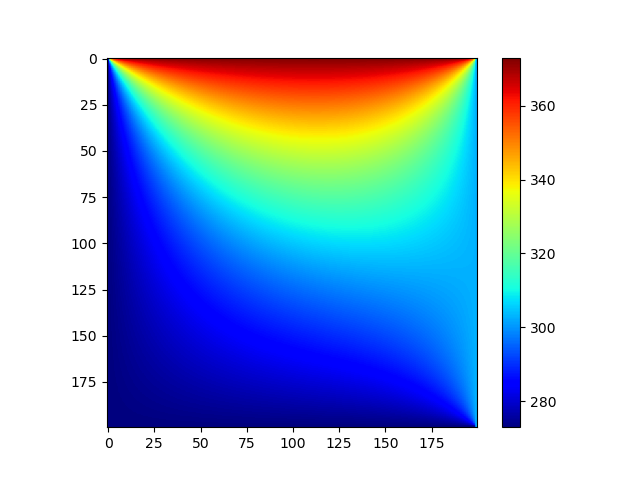

In [6]:
T = load("./data/conduction2D_t=0.npz")["T"]

fig = plt.figure()
ax = plt.axes()
im = plt.imshow(T, vmax=373, vmin=273, cmap="jet")
plt.colorbar()

inter = 1000
ifps = 1

def init():
    im.set_data(T)
    return [im]

def animate(i):
    if i % ifps == 0:
        T = load("./data/conduction2D_t=%d.npz" % (int(i/ifps)*inter))["T"]
        im.set_array(T)
    return [im]

ani = an.FuncAnimation(fig, animate, range(int(ifps*M/inter)), init_func=init,
                              interval=1, blit=True, repeat=False)
plt.show()